In [0]:
!pip install imgaug
!pip install Cython
!pip install pycocotools
!pip install kaggle

In [0]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 914 (delta 0), reused 0 (delta 0), pack-reused 913
Receiving objects: 100% (914/914), 112.91 MiB | 28.84 MiB/s, done.
Resolving deltas: 100% (537/537), done.


In [0]:
!unzip 'Mask_RCNN-2.1'

In [0]:
cd ..


/content


In [0]:
ls

In [0]:
import os 
os.chdir('Mask_RCNN-2.1')

In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/balloon"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))
    

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log
#import balloon


%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "/path/to/mask_rcnn_balloon.h5"  # TODO: update this path

Using TensorFlow backend.


In [0]:
os.chdir('samples/balloon')

In [0]:
import balloon

In [0]:
from config import Config
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

In [0]:
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/balloon")

In [0]:
BALLOON_DIR

'/content/Mask_RCNN-2.1/datasets/balloon'

In [0]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 30
Class Count: 2
  0. BG                                                
  1. car                                               


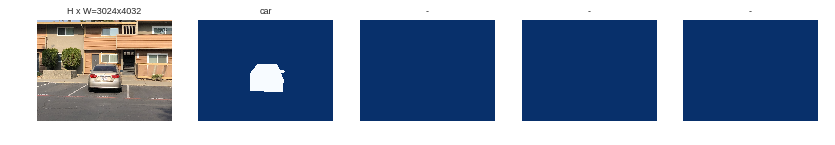

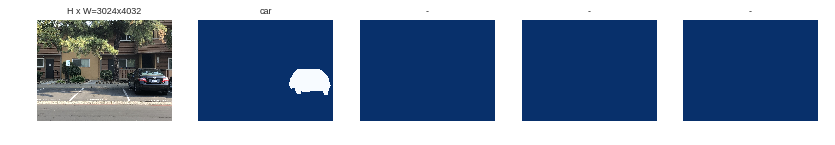

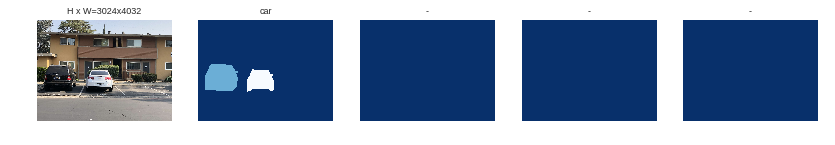

In [0]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 3)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  9 /content/Mask_RCNN-2.1/datasets/balloon/train/IMG_4491.jpg
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000
mask                     shape: (3024, 4032, 2)       min:    0.00000  max:    1.00000
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000
bbox                     shape: (2, 4)                min: 1239.00000  max: 3872.00000


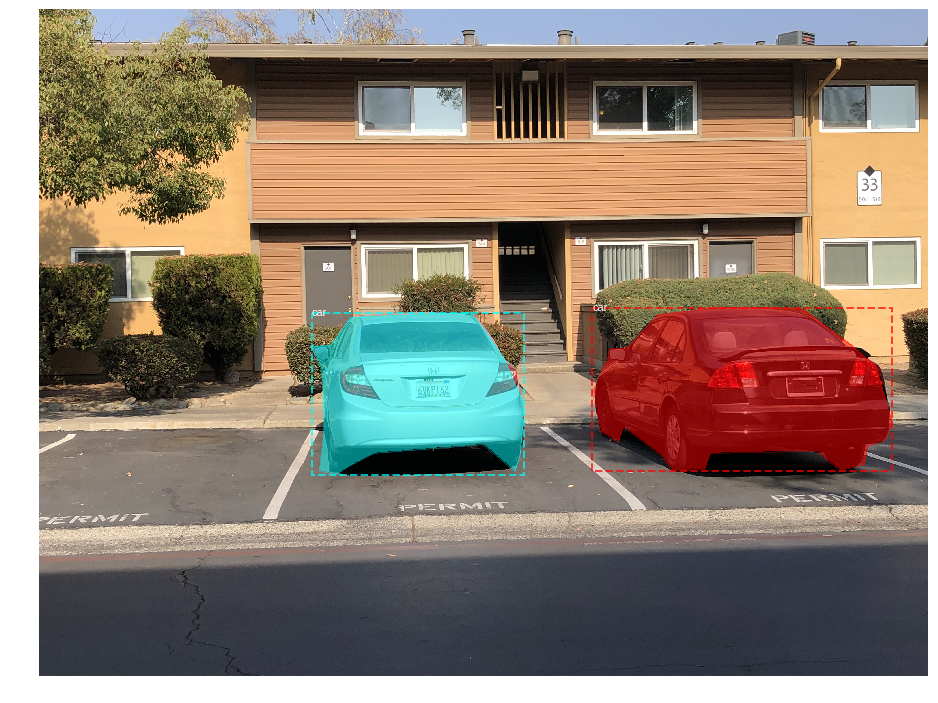

In [0]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id:  21 /content/Mask_RCNN-2.1/datasets/balloon/train/IMG_4511.jpg
Original shape:  (3024, 4032, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
bbox                     shape: (1, 4)                min:  385.00000  max: 1020.00000


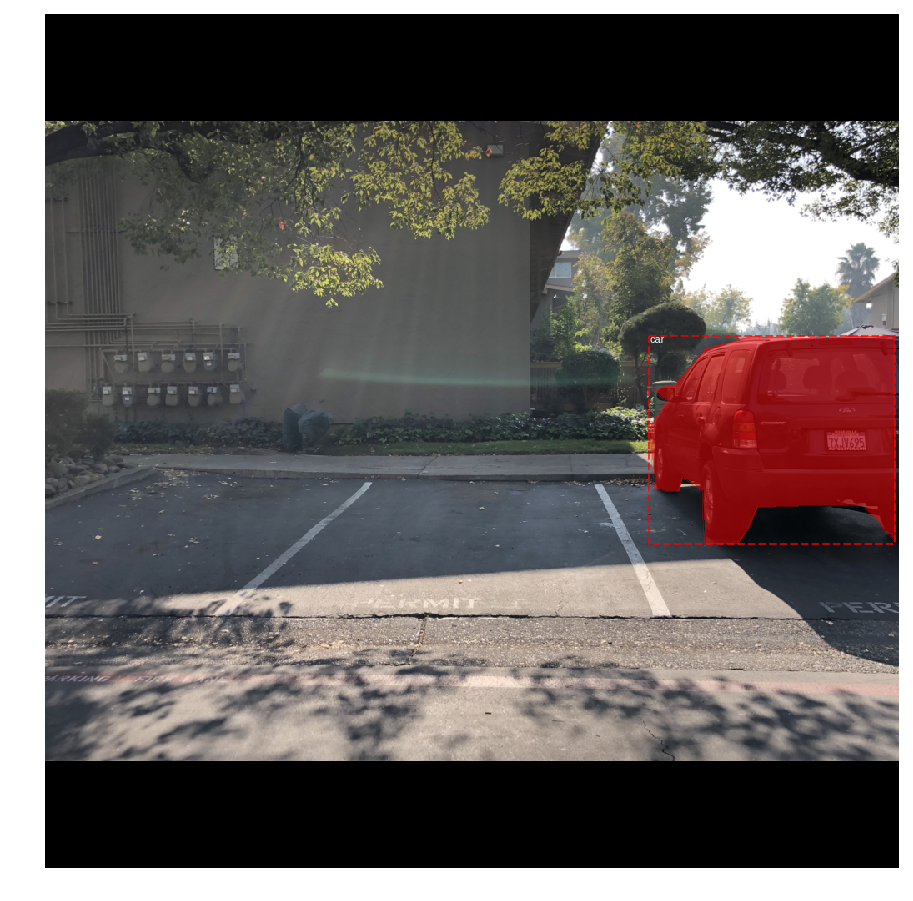

In [0]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    padding=config.IMAGE_PADDING)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [0]:
cd ..

/content/Mask_RCNN-2.1


In [0]:
import model as modellib
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [0]:
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

In [0]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

In [0]:
import keras
# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [0]:
    dataset_train = balloon.BalloonDataset()
    dataset_train.load_balloon(BALLOON_DIR, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = balloon.BalloonDataset()
    dataset_val.load_balloon(BALLOON_DIR, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN-2.1/car20181128T0044/mask_rcnn_car_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribute

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
100/100 [==============================] - 281s 3s/step - loss: 0.3714 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.1264 - val_loss: 0.1871 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.0141 - val_mrcnn_class_loss: 0.0018 - val_mrcnn_bbox_loss: 0.0378 - val_mrcnn_mask_loss: 0.1300
Epoch 2/30
100/100 [==============================] - 227s 2s/step - loss: 0.1986 - rpn_class_loss: 8.7903e-04 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0573 - mrcnn_mask_loss: 0.1052 - val_loss: 0.1476 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.0261 - val_mrcnn_class_loss: 9.8078e-04 - val_mrcnn_bbox_loss: 0.0228 - val_mrcnn_mask_loss: 0.0935
Epoch 3/30
100/100 [==============================] - 224s 2s/step - loss: 0.1602 - rpn_class_loss: 8.8250e-04 - rpn_bbox_loss: 0.0345 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0983 - val_loss: 0.1362 - val

In [0]:
cd ..

/content/Mask_RCNN-2.1


In [0]:
import model as modellib
# Create model object in inference mode.
model1 = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model1.load_weights('car_model/mask_rcnn_car_0030.h5', by_name=True)

Processing 2 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (2, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (2, 10)               min:    0.00000  max: 4032.00000
8 cars appears in Image.


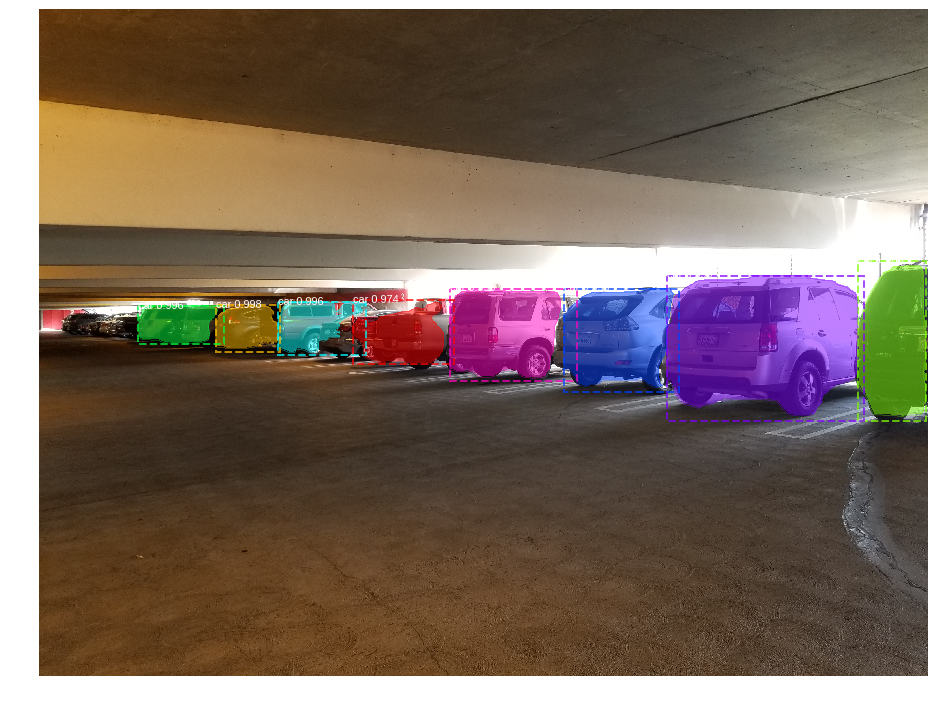

In [0]:
# Load a random image from the images folder
file_names = next(os.walk('datasets/balloon/test'))[2]
image = skimage.io.imread(os.path.join('datasets/balloon/test', random.choice(file_names)))

# Run detection
results = model1.detect([image,image], verbose=1)

# Visualize results
r = results[0]
y=len(r['class_ids'])
y
print("%d cars appears in Image." % (y))
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'])





In [0]:
r


{'class_ids': array([1, 1], dtype=int32), 'masks': array([[[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        ...,
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]]], dtype=uint8), 'rois': array([[1134,    0, 2004, 1004],
        [1386, 2547, 2216, 3984]], dtype=int32), 'scores': array([0.99891543, 0.998271  ], dtype=float32)}

In [0]:
COCO_WEIGHTS_PATH = "car_model/mask_rcnn_car_0030.h5"

In [0]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

In [0]:
import keras
# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])